# Model Evaluation

This notebook is a culmination of all of the $\mathcal{GP}$ modelling which has been undertaken in order to forecast solar cycles.

In this notebook we evaluate:

* The RMSE and MAE of the different $\mathcal{GP}$ models
* The Matern 5/2 $\times$ Periodic kernel's ability to forecast with different training splits
* The effect of modelling with and without the sine-squared mean function
* The Matern 5/2 $\times$ Periodic kernel's ability to forecsat far into the future

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv

## Model Comparison

In [26]:
folder_path = 'Data/GP Metrics/Skips-400/Split 3'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

print(file_names)

['Matern_Per_errors.csv', 'SE_Per_errors.csv', 'RatPer_errors.csv', 'SE_Cos_errors.csv', 'Matern32_Per_errors.csv', 'Rat_plus_Per_errors.csv', 'SE_plus_Per_errors.csv']


In [31]:
model_names = ['Matern 5/2 X Periodic', 
                   f'SE X Periodic',
                   f'RQ X Periodic',
                   f'SE X Cosine',
                   'Matern 3/2 X Periodic',
                   #'Non-Stationary 2',
                   f'RQ $\plus$ Periodic',
                   #'Non-Stationary',
                   f'SE $\plus$ Periodic',
                  ]

splits = np.arange(1,4)

data = []
for file in file_names:
    model_data = []
    for split in splits:
        filename = f'Data/GP Metrics/Skips-400/Split {str(split)}/{file}'
        try:
            with open(filename, newline='') as csvfile:
                reader = csv.DictReader(csvfile)
                
                rmse_values = []
                mae_values = []
                
                for row in reader:
                    if row['Metric'] == 'MSE':
                        rmse_values.append(np.sqrt(float(row['Value'])))
                    elif row['Metric'] == 'MAE':
                        mae_values.append(float(row['Value']))

                mean_rmse = np.mean(rmse_values)
                mean_mae = np.mean(mae_values)

                model_data.append([mean_rmse, mean_mae])
            #print(filename)
        except FileNotFoundError:
            print(f"File {filename} not found")
        
    data.append(model_data)

#print(data)
print(model_data)

[[10.76111420214845, 9.407098511405424], [36.36946070794157, 22.277474623799733], [44.074972352131695, 38.156653315372246]]


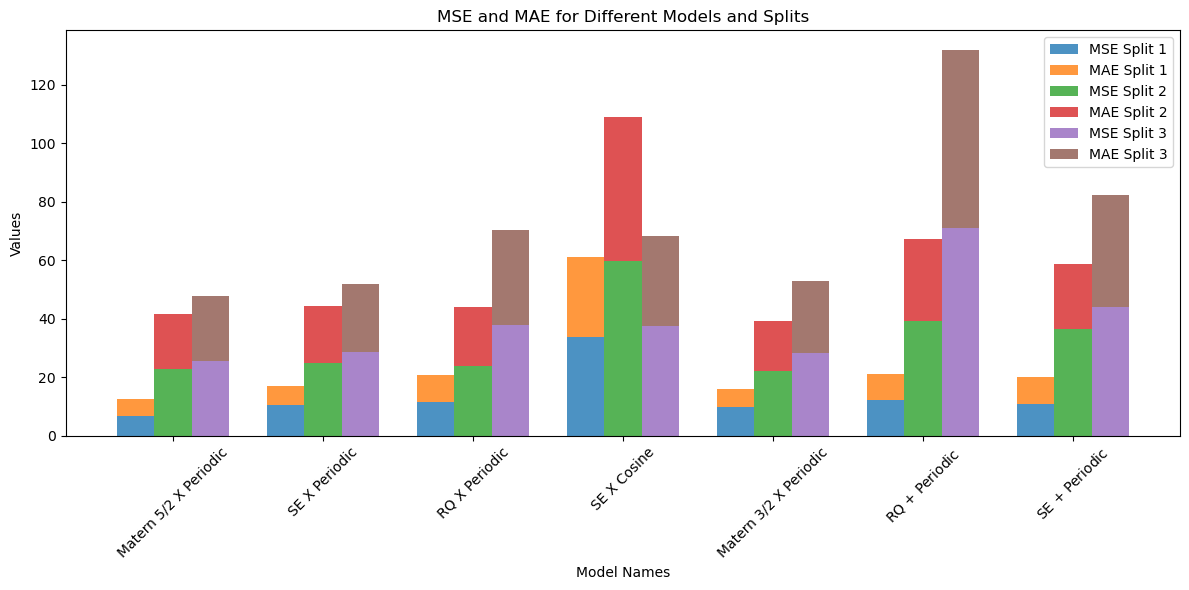

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the 'data' variable is already filled with the MSE and MAE values
# Example data format: [[[mse1, mae1], [mse2, mae2], [mse3, mae3]], ...]

n_models = len(model_names)
n_splits = len(splits)
bar_width = 0.25
opacity = 0.8

mse_values = [[model_data[split][0] for model_data in data] for split in range(n_splits)]
mae_values = [[model_data[split][1] for model_data in data] for split in range(n_splits)]

index = np.arange(n_models)
plt.figure(figsize=(12, 6))

for i in range(n_splits):
    plt.bar(index + i * bar_width, mse_values[i], bar_width, alpha=opacity, label=f"MSE Split {i+1}")
    plt.bar(index + i * bar_width, mae_values[i], bar_width, bottom=mse_values[i], alpha=opacity, label=f"MAE Split {i+1}")

plt.xlabel('Model Names')
plt.ylabel('Values')
plt.title('MSE and MAE for Different Models and Splits')
plt.xticks(index + bar_width, model_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

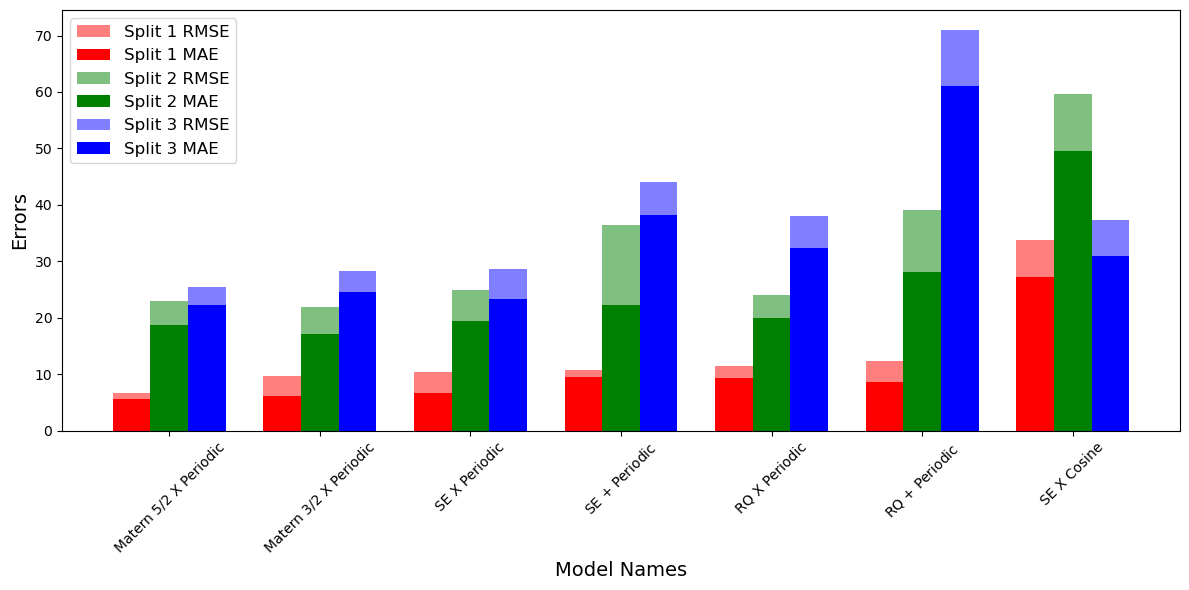

In [33]:
# Define the bar colors for each split
split_colors = ['red', 'green', 'blue']
alpha = 1

# Sort the models based on Split 3 MSE values
sorted_indices = sorted(range(n_models), key=lambda i: data[i][0][0])  # Indices sorted by Split 3 MSE
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_data = [data[i] for i in sorted_indices]

mse_values = [[model_data[split][0] for model_data in sorted_data] for split in range(n_splits)]
mae_values = [[model_data[split][1] for model_data in sorted_data] for split in range(n_splits)]

index = np.arange(n_models)
plt.figure(figsize=(12, 6))

for i in range(n_splits):
    mse_color = split_colors[i]
    mae_color = split_colors[i]  # Add 50% alpha to the color for MAE bars
    plt.bar(index + i * bar_width, mse_values[i], bar_width, alpha=0.5, label=f"Split {i+1} RMSE", color=mse_color)
    plt.bar(index + i * bar_width, mae_values[i], bar_width, bottom=None, label=f"Split {i+1} MAE", alpha=alpha, color=mae_color)

plt.xlabel('Model Names', size=14)
plt.ylabel('Errors', size=14)
#plt.title('MSE and MAE for Different Models and Splits (Sorted by Split 1 MSE)')
plt.xticks(index + bar_width, sorted_model_names, rotation=45)
plt.legend(loc='upper left', prop={'size':12})

plt.tight_layout()
#plt.savefig('Figures/model_errors.png')
plt.show()

## Qualitative Model Evaluation

In [6]:
df = pd.read_csv('Data/Savitzky-Golay Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values

In [7]:
# load the data from the CSV file
#model = pd.read_csv("../GP Model Data/Skips-400/Split 3/MaternPer.csv", index_col=0)
model = [pd.read_csv(f"Data/GP Model Data/Skips-400/Split {str(i)}/MaternPer.csv", index_col=0) for i in range(1,4)]

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


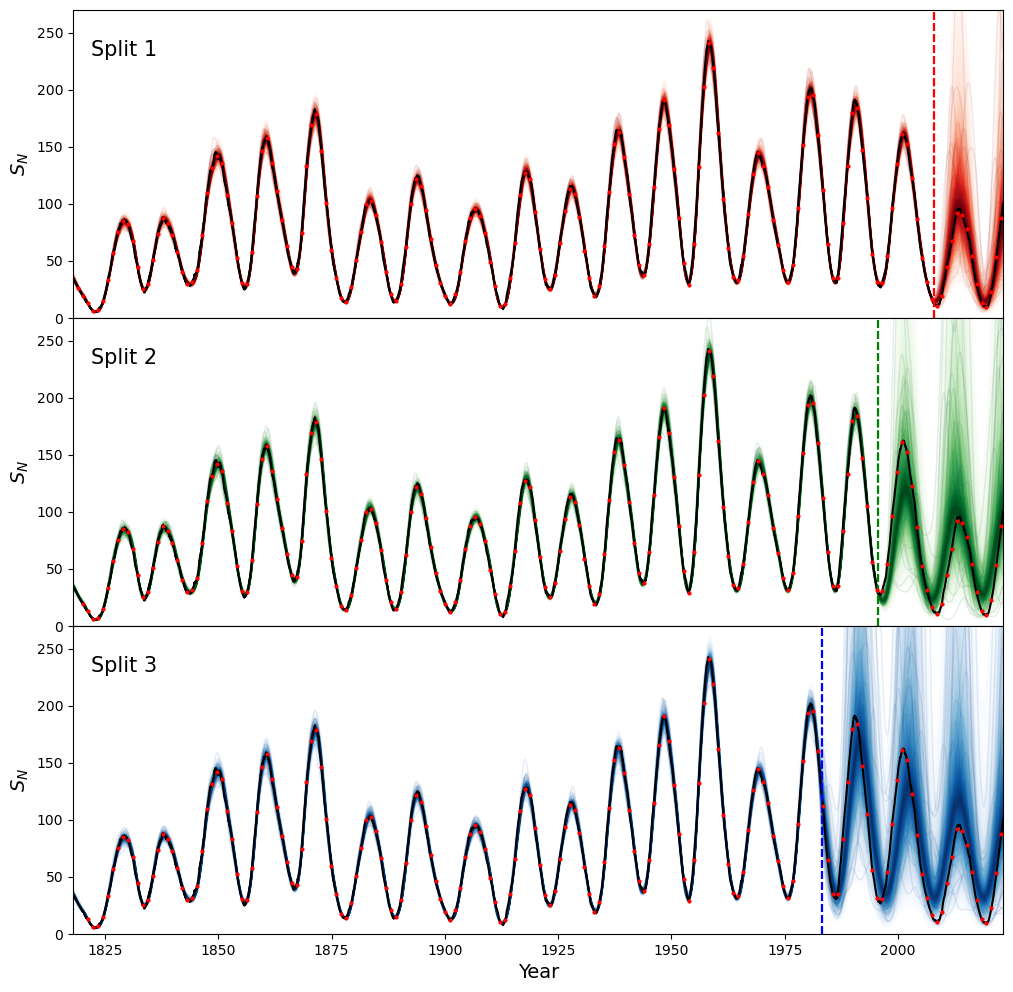

In [8]:
import pymc3
from pymc3.gp.util import plot_gp_dist

limit1 = int(0.925*len(X))# end point of full data when training
limit2 = int(0.865*len(X))
limit3 = int(0.805*len(X))

X_new = np.linspace(1818, 2023, 1000)[:, None]

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.subplots_adjust(hspace=0.)  # adjust the spacing between subplots

colors=['Reds', 'Greens', 'Blues']

# Plot subplots
for i in range(3):
    axs[i].set_ylim(0,270)
    axs[i].set_xlim(1818,2023.2)
    plot_gp_dist(axs[i], model[i].values, X_new, palette=colors[i])
    axs[i].plot(X, y, color='k')
    axs[i].scatter(X[(i+1)*400::400], y[(i+1)*400::400], color='red',s=4, zorder=99)
    axs[0].axvline(x=X[limit1], linestyle='--', color=split_colors[0], label='Split 1')
    axs[1].axvline(x=X[limit2], linestyle='--', color=split_colors[1], label='Split 2')
    axs[2].axvline(x=X[limit3], linestyle='--', color=split_colors[2], label='Split 3')
    axs[i].text(X[0]+ 4, 230, f"Split {i+1}", fontsize=15, fontweight='normal') # Add text label for each subplot
    axs[i].set_ylabel('$S_N$', size=14)
    if i != 2:
        axs[i].set_xlabel('')
        axs[i].set_xticks([]) 
axs[-1].set_xlabel("Year", size=14)  # set x-label for the final subplot

plt.savefig('Figures/Matern52_results.png')
plt.show()

## Mean vs No Mean

In [9]:
nm_model = pd.read_csv(f"Data/GP Model Data/No Mean/MaternPer_no_mean.csv", index_col=0)
m_model = pd.read_csv(f"Data/GP Model Data/Skips-400/Split 3/MaternPer.csv", index_col=0)

models = [m_model, nm_model]

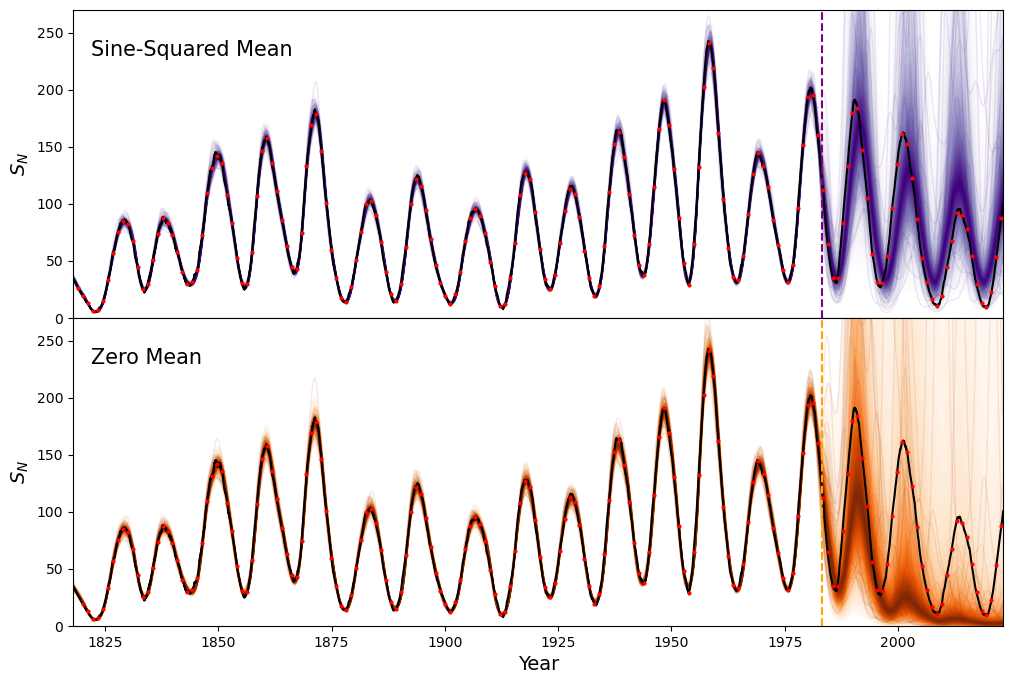

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.)  # adjust the spacing between subplots

Colors=['Purples', 'Oranges']
colors=['purple', 'orange']
txt = ['Sine-Squared Mean', 'Zero Mean']

# Plot subplots
for i in range(2):
    axs[i].set_ylim(0,270)
    axs[i].set_xlim(1818,2023.2)
    plot_gp_dist(axs[i], models[i].values, X_new, palette=Colors[i])
    axs[i].plot(X, y, color='k')
    axs[i].scatter(X[(i+1)*400::400], y[(i+1)*400::400], color='red',s=4, zorder=99)
    axs[i].axvline(x=X[limit3], linestyle='--', color=colors[i])
    axs[i].text(X[0]+ 4, 230, txt[i], fontsize=15, fontweight='normal') # Add text label for each subplot
    axs[i].set_ylabel('$S_N$', size=14)
    if i != 1:
        axs[i].set_xlabel('')
        axs[i].set_xticks([]) 
axs[-1].set_xlabel("Year", size=14) 
plt.savefig('Figures/mean_plot.png')
plt.show()

In [11]:
nm_model_errors = pd.read_csv("Data/GP Metrics/No Mean/Matern_Per_no_mean_errors.csv", index_col=0)
m_model_errors = pd.read_csv("Data/GP Metrics/Skips-400/Split 3/Matern_Per_errors.csv", index_col=0)

nm_RMSE = np.sqrt(nm_model_errors.values[0][0])
m_RMSE = np.sqrt(m_model_errors.values[0][0])
p_diff = (nm_RMSE-m_RMSE)/m_RMSE * 100

print(f"No Mean Model RMSE = {nm_RMSE:.2f}")
print(f"Mean Model RMSE = {m_RMSE:.2f}")
print(f"Percentage Difference = {p_diff:.2f}%")

No Mean Model RMSE = 59.11
Mean Model RMSE = 25.40
Percentage Difference = 132.72%


## Long-term Predictions

In [12]:
long_model = pd.read_csv(f"Data/GP Model Data/MaternPer_long.csv", index_col=0)

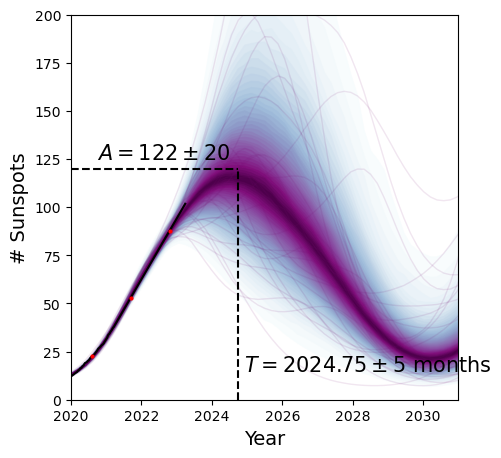

In [13]:
X_new = np.linspace(1818, 2100, 1500)[:, None]

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(hspace=0.)  # adjust the spacing between subplots

# Plot subplots
axs.set_ylim(0,200)
axs.set_xlim(2020,2031)
plot_gp_dist(axs, long_model.values, X_new, palette='BuPu')
axs.plot(X, y, color='k')
axs.scatter(X[(i+1)*400::400], y[(i+1)*400::400], color='r',s=4, zorder=99)
axs.axvline(x=2024.74, ymin=0, ymax=120/200, linestyle='--', color='k')
axs.axhline(y=120, xmin=0, xmax=4.74/11, linestyle='--', color='k')
axs.text(2020.74, 125, '$A = 122 \pm 20$', fontsize=15, fontweight='normal')
axs.text(2024.9, 15, '$T = 2024.75 \pm 5$ months', fontsize=15, fontweight='normal')# Add text label for each subplot
axs.set_ylabel('# Sunspots', size=14)
axs.set_xlabel("Year", size=14) 
plt.show()

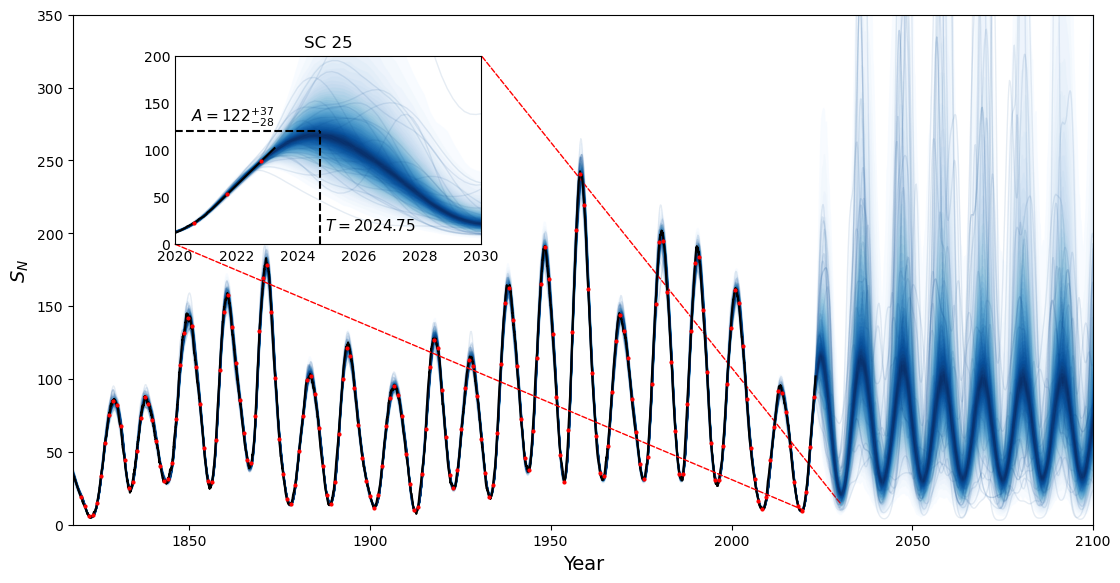

In [14]:
from matplotlib.patches import ConnectionPatch

X_new = np.linspace(1818, 2100, 1500)[:, None]

# Create the main figure and subplot
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.1, left=0.1, right=0.95, bottom=0.1, top=0.95)  # adjust the spacing and margins

# Create a smaller subplot inside the main subplot
ax_zoom = axs.inset_axes([0.1, 0.55, 0.3, 0.37], zorder=99)
ax_zoom.set_ylim(0,200)
ax_zoom.set_xlim(2020,2030)
plot_gp_dist(ax_zoom, long_model.values, X_new, palette='Blues')
ax_zoom.plot(X, y, color='k')
ax_zoom.scatter(X[(i+1)*400::400], y[(i+1)*400::400], color='r',s=4, zorder=99)
ax_zoom.axvline(x=2024.74, ymin=0, ymax=120/200, linestyle='--', color='k')
ax_zoom.axhline(y=120, xmin=0, xmax=4.74/10, linestyle='--', color='k')
ax_zoom.text(2020.5, 130, '$A = 122^{+37}_{-28}$', fontsize=11, fontweight='normal')
ax_zoom.text(2024.9, 15, '$T = 2024.75$', fontsize=11, fontweight='normal')
#ax_zoom.set_xticklabels([])
#ax_zoom.set_yticklabels([])
ax_zoom.tick_params(axis='both', length=0, width=0)
ax_zoom.set_title('SC 25', size=12)

# Plot the main subplot
axs.set_ylim(0,350)
axs.set_xlim(1818,2100)
plot_gp_dist(axs, long_model.values, X_new, palette='Blues')
axs.plot(X, y, color='k')
axs.scatter(X[(i+1)*400::400], y[(i+1)*400::400], color='r',s=4, zorder=98)
axs.set_ylabel('$S_N$', size=14)
axs.set_xlabel("Year", size=14) 

# Add ConnectionPatches to connect the two subplots
con = ConnectionPatch(xyA=(2030, 15), coordsA=axs.transData, 
                      xyB=(2030, 200), coordsB=ax_zoom.transData, 
                      color='red', linestyle='--', linewidth=1)
axs.add_artist(con)

con = ConnectionPatch(xyA=(2020, 0), coordsA=ax_zoom.transData, 
                      xyB=(2020, 10), coordsB=axs.transData, 
                      color='red', linestyle='--', linewidth=1)
ax_zoom.add_artist(con)

plt.savefig('Figures/future predictions.png')
plt.show()

## Finding the Peak of SC 25

In [15]:
from scipy.signal import find_peaks
from scipy.signal import argrelmin

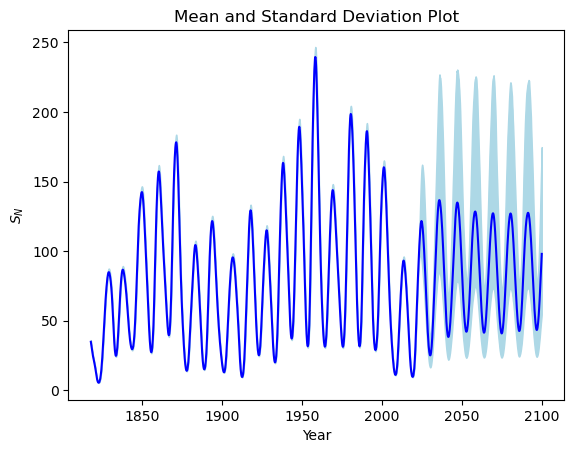

In [16]:
import matplotlib.pyplot as plt
import numpy as np

samples = long_model.values
# Calculate mean and standard deviation
mu = np.mean(samples, axis=0)
std = np.std(samples, axis=0)

# Calculate the deviations for each sample
deviations = samples - mu

# Group the deviations by sign and mean for each mean point
positive_deviations = np.where(deviations > 0, deviations, np.nan)
negative_deviations = np.where(deviations < 0, deviations, np.nan)
errors_above = np.nanmean(positive_deviations, axis=0)
errors_below = np.nanmean(negative_deviations, axis=0)

# Create x-axis values
x = np.linspace(1818, 2100, 1500)

# Create figure and axis objects
fig, ax = plt.subplots()

# Plot mean line
ax.plot(x, mu, color='blue')

# Fill in area around mean line with one standard deviation
ax.fill_between(x, mu + errors_below, mu + errors_above, color='lightblue')

# Add axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('$S_N$')
ax.set_title('Mean and Standard Deviation Plot')

# Show plot
plt.show()

In [17]:
peaks = find_peaks(mu, height=50, distance=11) 
troughs = argrelmin(mu, order=11)

maxima = mu[peaks[0]]
minima = mu[troughs[0]]

dates_peak = X_new[peaks[0]] # dates of the maxima for each SVG signal
dates_minima = X_new[troughs[0]] 

In [18]:
maxima[-7]

121.63300056816453

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


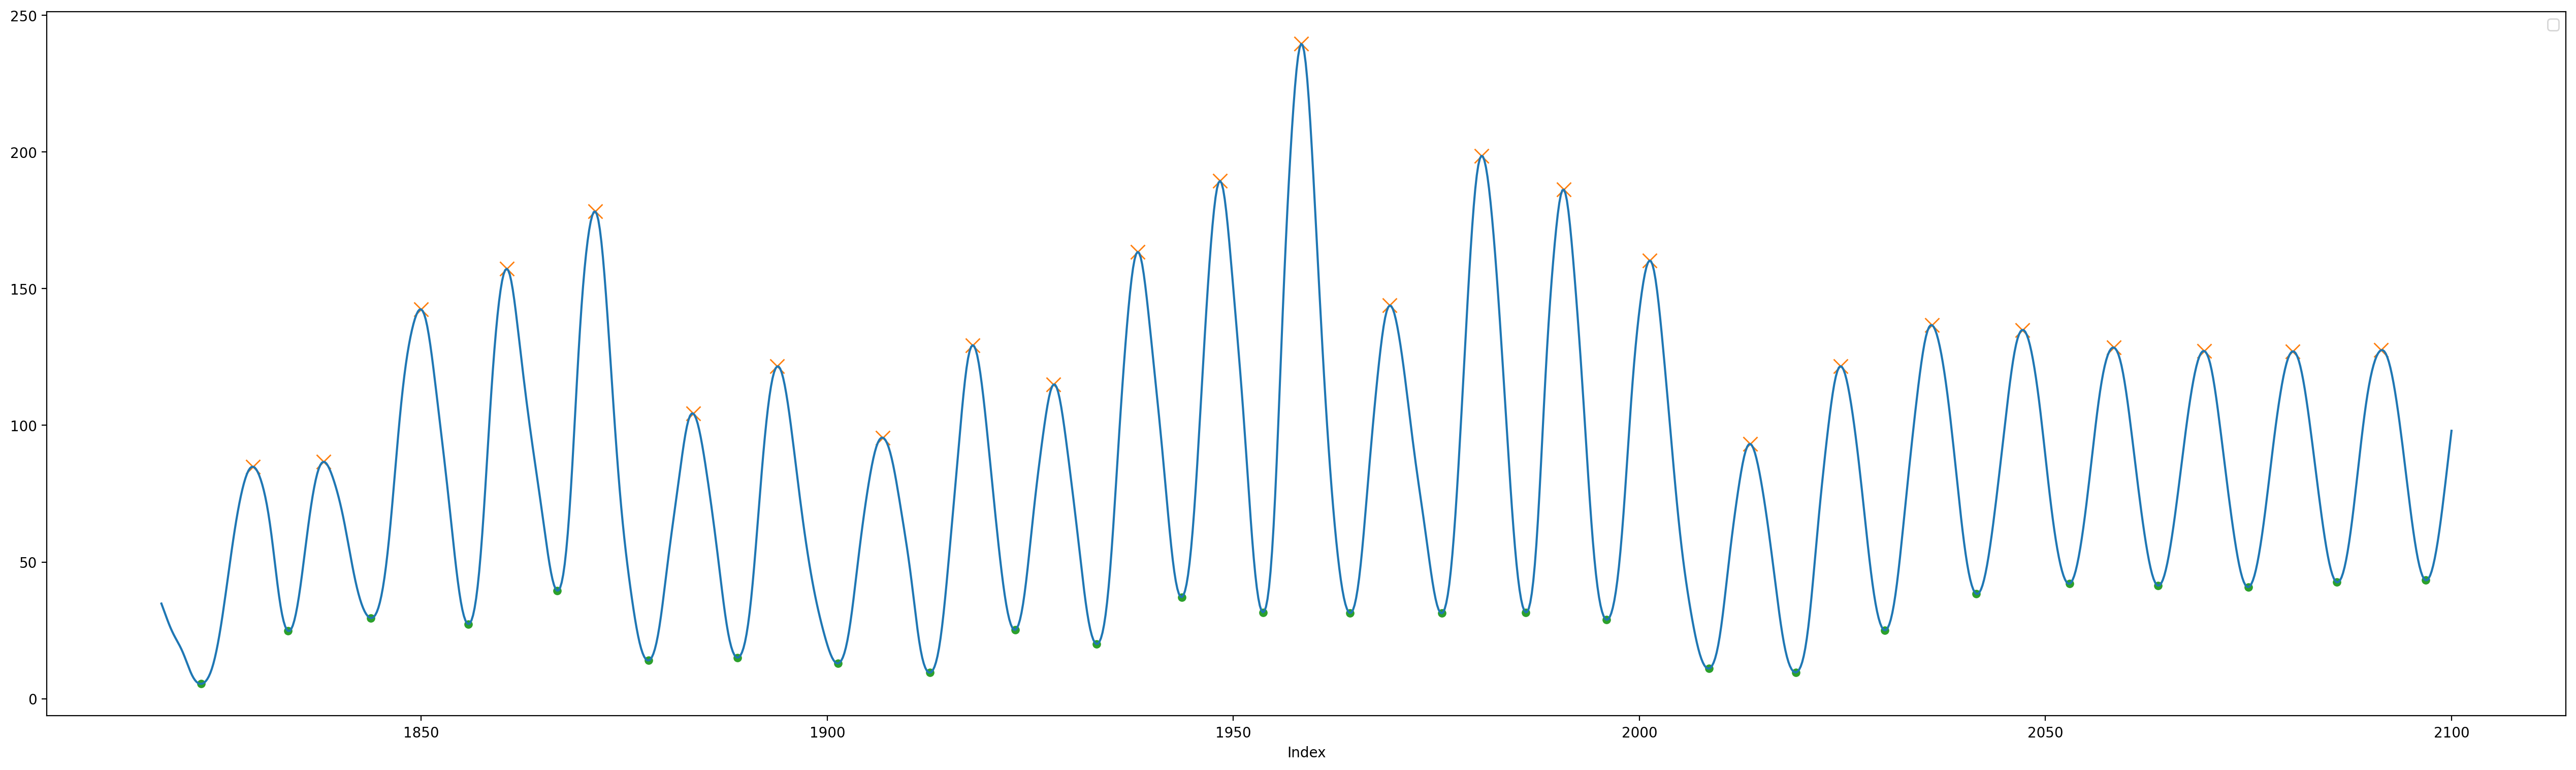

In [19]:
msize = 10 # size of marker

fig, ax = plt.subplots(dpi=200, figsize=[32, 9])
ax.plot(X_new, mu, zorder=99)
ax.plot(dates_peak, maxima, 'x', markersize=msize)
ax.plot(dates_minima, minima, '.', markersize=msize)
ax.set_xlabel('Index')
#ax.set_ylabel(ycol)
ax.legend();

In [20]:
print(f"The amplitude for SC 25 will be {maxima[-7]:.0f}")
print(f"The maxima will occur in {dates_peak[-7][0]:.2f}, and subsequent minima in {dates_minima[-7][0]:.2f}")

The amplitude for SC 25 will be 122
The maxima will occur in 2024.75, and subsequent minima in 2030.21


In [21]:
# Find the index of the last maximum in the mu array
max_index = np.where(mu == maxima[-7])[0][0]
min_index = np.where(mu == minima[-7])[0][0]

# Find the errors above and below the mean for the maximum
error_above = errors_above[max_index]
error_below = errors_below[max_index]

# Find the errors above and below the mean for the minima
error_above2 = errors_above[min_index]
error_below2 = errors_below[min_index]

# Print the errors
print(f"Error above the max mean: {error_above}")
print(f"Error below the max mean: {error_below}")
print("")
print(f"Error above the min mean: {error_above2}")
print(f"Error below the min mean: {error_below2}")

Error above the max mean: 37.082354537233364
Error below the max mean: -27.596170818406218

Error above the min mean: 13.455126728173628
Error below the min mean: -8.602458072111
